# CNN Implementation from Scratch

## Imports

We begin by importing essential Python libraries:

- **pandas**: for data manipulation and analysis.
- **numpy**: for numerical operations and handling arrays.
- **matplotlib.pyplot**: for data visualization and plotting results.

These libraries provide the fundamental tools required to preprocess data, implement the CNN, and visualize its performance.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Loading the MNIST Dataset

We load the training and testing datasets from CSV files:

- `mnist_train.xls`: contains the training images and labels.
- `mnist_test.xls`: contains the testing images and labels.

These datasets will be used to train and evaluate our CNN model implemented from scratch.


In [2]:
df_train = pd.read_csv('mnist_train.xls')
df_test = pd.read_csv('mnist_test.xls')

## Data Preprocessing and Reshaping

- Convert the loaded DataFrames to NumPy arrays for faster processing.
- Shuffle the training data randomly to ensure the model learns generalized patterns.
- Separate labels (`Y_train`, `Y_test`) from the pixel data.
- Normalize pixel values by scaling them between 0 and 1 (`/ 255.0`) for better model convergence.
- Reshape the input data to match the expected CNN input shape:  
  `(number_of_samples, channels, height, width)`  
  Here, channels = 1 since the MNIST images are grayscale, and image size is 28x28 pixels.


In [3]:
train_data = df_train.values
test_data = df_test.values

np.random.shuffle(train_data)

Y_train = train_data[:, 0].astype(int)         
X_train = train_data[:, 1:] / 255.0 

Y_test = test_data[:, 0].astype(int)
X_test = test_data[:, 1:] / 255.0

X_train = X_train.reshape(-1, 1, 28, 28)
X_test = X_test.reshape(-1, 1, 28, 28)


## Model Initialization and Utility Functions

### Parameter Initialization
- Initialize weights and biases for each layer with small random values (centered around zero) to break symmetry.
- Conv Layer 1: 8 filters, 1 input channel, kernel size 3x3.
- Conv Layer 2: 16 filters, 8 input channels, kernel size 3x3.
- Fully Connected (FC) Layer 1: 128 neurons.
- FC Layer 2: 10 output neurons corresponding to the 10 digit classes.

### Activation Functions
- **ReLU** (`relu`): Applies the Rectified Linear Unit activation, which sets negative values to zero.
- **Derivative of ReLU** (`der_relu`): Used during backpropagation to compute gradients.
- **Softmax** (`softmax`): Converts logits to probability distribution over output classes, with numerical stability adjustments.

### One-Hot Encoding
- Converts integer class labels into one-hot encoded vectors for multi-class classification.

### Loss Function
- **Cross-Entropy Loss** (`loss_function`): Measures the difference between the true labels and predicted probabilities, penalizing incorrect predictions.

### Flattening Functions
- `flatten`: Reshapes multidimensional arryas into 2D arrays for transitioning from convolutional to fully connected layers.
- `flatten_backward`: Reshapes gradients back to the original array shape during backpropagation.


In [4]:
def initialize_parameters():
    params = {}

    # Conv Layer 1: 8 filters, 1 channel, 3x3 kernel
    params['W1'] = np.random.rand(8,1,3,3) - 0.5
    params['b1'] = np.zeros((8,))

    # Conv Layer 2: 16 filters, 8 channels, 3x3 kernel
    params['W2'] = np.random.rand(16,8,3,3) - 0.5
    params['b2'] = np.zeros((16,))

    # FC Layer 1: 128 neurons
    params['W3'] = np.random.rand(128,16*7*7) - 0.5
    params['b3'] = np.zeros((128,))

    # FC Layer 2: 10 output classes
    params['W4'] = np.random.rand(10,128) - 0.5
    params['b4'] = np.zeros((10,))

    return params

def relu(Z):
    return np.maximum(Z,0)

def softmax(Z):
    expZ = np.exp(Z - np.max(Z, axis=1, keepdims=True))  # Stability trick
    return expZ / np.sum(expZ, axis=1, keepdims=True)

def der_relu(Z):
    return (Z>0).astype(float)

def one_hot_encode(Y):
    one_hot_Y = np.zeros((Y.shape[0],10))
    one_hot_Y[np.arange(Y.shape[0]), Y] = 1
    return one_hot_Y

#cross entropy loss function
def loss_function(y_true, y_pred):
    m = y_true.shape[0]
    # Avoid log(0)
    epsilon = 1e-12
    y_pred = np.clip(y_pred, epsilon, 1. - epsilon)
    return -np.sum(y_true * np.log(y_pred))/m

def flatten(Z):
    return Z.reshape(Z.shape[0], -1)

def flatten_backward(dZ, A_prev_shape):
    return dZ.reshape(A_prev_shape)




## Convolution Operations from Scratch

### `im2col` Function
- Converts the input array into columns to simplify the convolution operation as a matrix multiplication.
- Takes input array `Z` with shape `(N, C, H, W)`.
- Applies zero-padding around the input to maintain spatial dimensions.
- Extracts sliding windows of size `kernel_size` over the input with specified `stride`.
- Rearranges these windows into a 2D matrix where each row corresponds to a receptive field.
- Returns the transformed matrix along with the calculated output height and width.

### `conv2d` Function
- Performs 2D convolution by leveraging the `im2col` transformation.
- Takes input `Z`, filters `W`, biases `b`, stride, and padding as parameters.
- Reshapes the filters into a compatible 2D matrix.
- Multiplies the input columns with the transposed filters to produce the convolved output.
- Adds bias and reshapes the output back to the 4D array format `(N, C_out, H_out, W_out)`.

This efficient implementation replaces explicit nested loops with matrix multiplication for faster computation.


In [5]:
def im2col(Z, kernel_size, stride=1, padding=1):
    N, C, H, W = Z.shape
    kH, kW = kernel_size

    # Pad input
    Z_padded = np.pad(Z, ((0,0), (0,0), (padding, padding), (padding, padding)), mode='constant')

    H_out = (H + 2 * padding - kH) // stride + 1
    W_out = (W + 2 * padding - kW) // stride + 1

    col = np.zeros((N, C, kH, kW, H_out, W_out))

    for y in range(kH):
        y_max = y + stride*H_out
        for x in range(kW):
            x_max = x + stride*W_out
            col[:, :, y, x, :, :] = Z_padded[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N * H_out * W_out, -1)

    return col,H_out,W_out

def conv2d(Z,W,b,stride = 1,padding =1):
    N, C_in, H, W_ = Z.shape
    C_out, _, kH, kW = W.shape

    Z_col, H_out, W_out = im2col(Z, (kH, kW), stride=stride, padding=padding)  # shape: (N*H_out*W_out, C_in*kH*kW)
    W_col = W.reshape(C_out, -1)                                               # shape: (C_out, C_in*kH*kW)

    Z_out = Z_col @ W_col.T + b                                                  # shape: (N*H_out*W_out, C_out)
    Z_out = Z_out.reshape(N, H_out, W_out, C_out).transpose(0, 3, 1, 2)            # shape: (N, C_out, H_out, W_out)
    return Z_out,Z_col


## Max Pooling Layer Implementation

The `max_pool` function performs downsampling of feature maps by:

- Taking non-overlapping or overlapping patches of size `size x size` from the input array `Z`.
- The stride determines the step size for moving the window across the input.
- Uses `numpy.lib.stride_tricks.as_strided` to create efficient sliding window views without copying data.
- Computes the maximum value within each sliding window, reducing the spatial dimensions.
- Returns the pooled output array, effectively summarizing the most prominent features and reducing computation for subsequent layers.


In [6]:
def max_pool(Z,size = 2,stride = 2):
    N,C,H,W = Z.shape

    H_out = (H - size) // stride + 1
    W_out = (W - size) // stride + 1

    shape = (N, C, H_out, W_out, size, size)
    strides = (
    Z.strides[0],                     # Batch stride
    Z.strides[1],                     # Channel stride
    stride * Z.strides[2],           # Vertical step (H)
    stride * Z.strides[3],           # Horizontal step (W)
    Z.strides[2],                     # Inner H for patch
    Z.strides[3],                     # Inner W for patch
)
    # Use numpy.lib.stride_tricks.as_strided to create a view of sliding windows
    windows = np.lib.stride_tricks.as_strided(Z, shape=shape, strides=strides)
    
    # Step 2: Take max over last two axes (size x size window)
    Z_out = windows.max(axis=(4,5))
    
    return Z_out


## Backpropagation for Convolution Layer

### `col2im` Function
- The inverse of `im2col`, this function reconstructs the gradient array with respect to the input `X` from the columnar gradient format `dX_col`.
- Accumulates gradients by adding overlapping contributions due to the sliding windows.
- Handles padding by removing it at the end to restore the original input shape.

### `conv2d_backward` Function
- Computes gradients for backpropagation through the convolutional layer.
- Inputs:
  - `d_out`: gradient flowing from the next layer.
  - `X`: original input to the convolution layer.
  - `W`: convolutional filters.
  - `X_col`: im2col transformed input (cached from forward pass).
- Steps:
  - Reshape gradients for matrix multiplication.
  - Calculate gradients w.r.t. input (`dX`) using `col2im`.
  - Calculate gradients w.r.t. weights (`dW`) and biases (`db`).
- Returns the gradients needed to update parameters and propagate errors backwards.


In [7]:
def col2im(dX_col, X_shape, kH, kW, stride, padding):
    N, C, H, W = X_shape
    H_out = (H + 2 * padding - kH) // stride + 1
    W_out = (W + 2 * padding - kW) // stride + 1

    dX_padded = np.zeros((N, C, H + 2 * padding, W + 2 * padding))
    dX_col_reshaped = dX_col.reshape(N, H_out, W_out, C, kH, kW).transpose(0, 3, 4, 5, 1, 2)

    for y in range(kH):
        y_max = y + stride * H_out
        for x in range(kW):
            x_max = x + stride * W_out
            dX_padded[:, :, y:y_max:stride, x:x_max:stride] += dX_col_reshaped[:, :, y, x, :, :]

    if padding > 0:
        return dX_padded[:, :, padding:-padding, padding:-padding]
    return dX_padded

def conv2d_backward(d_out, X, W, X_col, stride=1, padding=1):
    N, C_in, H, W_in = X.shape
    C_out, _, kH, kW = W.shape

    d_out_reshaped = d_out.transpose(0, 2, 3, 1).reshape(-1, C_out)
    W_col = W.reshape(C_out, -1)

    dX_col = np.dot(d_out_reshaped, W_col)  # (N*H_out*W_out, C_in*kH*kW)
    dX = col2im(dX_col, X.shape, kH, kW, stride, padding)

    dW = np.dot(d_out_reshaped.T, X_col).reshape(W.shape)
    db = d_out_reshaped.sum(axis=0)

    return dX, dW, db


## Backpropagation for Max Pooling Layer

The `max_pool_backward` function computes the gradient of the loss with respect to the input of the max pooling layer.

- **Inputs:**
  - `dZ`: Gradient of the loss w.r.t. the output of max pooling layer.
  - `A_prev`: Input activations to the max pooling layer during the forward pass.
  - `size` and `stride`: Pooling window size and stride.

- **Process:**
  - Uses `numpy.lib.stride_tricks.as_strided` to create sliding windows over `A_prev`.
  - Identifies the positions of maximum values in each pooling window (creating a mask).
  - Distributes the incoming gradient `dZ` only to the max locations, propagating zeros elsewhere.
  - Accumulates gradients properly to form the gradient w.r.t. the input of the max pooling layer (`dA_prev`).

This method ensures gradients flow correctly only through the neurons that were selected during the forward max pooling.


In [8]:
def max_pool_backward(dZ,A_prev,size=2,stride=2):
    
    N,C_out,H_out,W_out = dZ.shape
    _,C_in, H_in, W_in = A_prev.shape

    shape = (N, C_out, H_out, W_out, size, size)
    strides = (
        A_prev.strides[0],
        A_prev.strides[1],
        stride * A_prev.strides[2],
        stride * A_prev.strides[3],
        A_prev.strides[2],
        A_prev.strides[3]
    )

    windows = np.lib.stride_tricks.as_strided(A_prev, shape=shape, strides=strides)

    max_vals = np.max(windows, axis=(4, 5), keepdims=True)
    mask = (windows == max_vals)

    dZ_expanded = dZ[..., None, None]
    dA_windows = mask * dZ_expanded

    dA_prev = np.zeros_like(A_prev)

    for i in range(size):
        for j in range(size):
            h_indices = np.arange(H_out) * stride + i
            w_indices = np.arange(W_out) * stride + j
            for hi, h in enumerate(h_indices):
                for wi, w in enumerate(w_indices):
                    dA_prev[:, :, h, w] += dA_windows[:, :, hi, wi, i, j]
    return dA_prev

## `forward_backward` Function

This function implements both the forward and backward pass for a simple Convolutional Neural Network (CNN) with the following architecture:

### Architecture:
1. **Conv2D Layer 1** → ReLU → MaxPooling  
2. **Conv2D Layer 2** → ReLU → MaxPooling  
3. **Flatten**
4. **Fully Connected Layer (FC1)** → ReLU  
5. **Fully Connected Layer (FC2 / Output)** → Softmax

---

### **Forward Pass:**
- **Conv1**: Applies 8 filters of size (3x3), with stride=1, padding=1.
- **ReLU + MaxPool1**: Non-linearity followed by 2x2 max pooling → output shape (N, 8, 14, 14).
- **Conv2**: Applies 16 filters → output shape (N, 16, 14, 14).
- **ReLU + MaxPool2**: Output shape (N, 16, 7, 7).
- **Flatten**: Converts array to shape (N, 16×7×7).
- **FC1**: Dense layer with 128 units.
- **ReLU**
- **FC2 (Output)**: Dense layer with 10 units → Softmax for class probabilities.
- **Loss**: Cross-entropy loss with one-hot encoded labels.

---

### **Backward Pass:**
- Gradients are computed layer-by-layer from the loss backwards:
  - `dZ4`: Gradient of softmax loss w.r.t logits.
  - Backprop through **FC2** → `W4`, `b4`.
  - Backprop through **ReLU + FC1** → `W3`, `b3`.
  - Reshape gradient to match CNN output shape.
  - Backprop through **MaxPool2** and **ReLU**.
  - Backprop through **Conv2** → `W2`, `b2`.
  - Backprop through **MaxPool1** and **ReLU**.
  - Backprop through **Conv1** → `W1`, `b1`.

---

### **Parameter Update:**
- Standard gradient descent is applied:
```python
params[key] -= learning_rate * grads[key]


In [9]:
def forward_backward(X,Y,params,learning_rate = 0.01):
    
    #Forward pass
    # Conv Layer 1
    Z1,Z1_col = conv2d(X, params['W1'], params['b1'], stride=1, padding=1)  # output: (N, 8, 28, 28)
    A1 = relu(Z1)
    P1 = max_pool(A1, size=2, stride=2)  # output: (N, 8, 14, 14)

    # Conv Layer 2
    Z2,Z2_col = conv2d(P1, params['W2'], params['b2'], stride=1, padding=1)  # output: (N, 16, 14, 14)
    A2 = relu(Z2)
    P2 = max_pool(A2, size=2, stride=2)  # output: (N, 16, 7, 7)

    #Flatten
    F = flatten(P2)

    # Fully Connected Layer 1
    Z3 = np.dot(F, params['W3'].T) + params['b3']  # shape: (N, 128)
    A3 = relu(Z3)

    # Fully Connected Layer 2 (output layer)
    Z4 = np.dot(A3, params['W4'].T) + params['b4']  # shape: (N, 10)

    # Softmax
    output = softmax(Z4)  # shape: (N, 10)


    y = one_hot_encode(Y)
    #loss
    loss = loss_function(y,output)


    #backward pass
    grads = {}

    N = X.shape[0]

    # Output layer gradient
    dZ4 = (output - y) / N  # (N,10)
    grads['W4'] = np.dot(dZ4.T, A3)  # (10,128)
    grads['b4'] = np.sum(dZ4, axis=0)  # (10,)

    dA3 = np.dot(dZ4, params['W4'])  # (N,128)
    dZ3 = dA3 * der_relu(Z3)  # (N,128)
    grads['W3'] = np.dot(dZ3.T, F)  # (128, 16*7*7)
    grads['b3'] = np.sum(dZ3, axis=0)  # (128,)

    dF = np.dot(dZ3, params['W3'])  # (N, 16*7*7)
    dP2 = flatten_backward(dF,P2.shape)  # (N,16,7,7)

    dA2 = max_pool_backward(dP2, A2, size=2, stride=2)  # (N,16,14,14)
    dZ2 = dA2 * der_relu(Z2)  # (N,16,14,14)

    # Backprop conv2 layer
    dP1,grads['W2'], grads['b2'] = conv2d_backward(dZ2, P1, params['W2'],Z2_col, stride=1, padding=1)

    dA1 = max_pool_backward(dP1, A1, size=2, stride=2)  # (N,8,28,28)
    dZ1 = dA1 * der_relu(Z1)  # (N,8,28,28)

    # Backprop conv1 layer
    _,grads['W1'], grads['b1'] = conv2d_backward(dZ1, X, params['W1'],Z1_col, stride=1, padding=1)


    #Update params 
    for key in params.keys():
        params[key] -= learning_rate * grads[key]

    return loss, params

## Prediction Function for CNN

### `predict(X, params, batch_size=128)`
- Performs forward propagation on the entire dataset in batches to generate predictions.

### Steps:
1. **Batch Processing**: Iterates over the input `X` in chunks to manage memory usage.
2. **Forward Pass**:
   - **Conv Layer 1**:
     - Convolution → ReLU → Max Pooling
   - **Conv Layer 2**:
     - Convolution → ReLU → Max Pooling
   - **Flattening**: Converts 4D array output into 2D for the fully connected layer.
   - **Fully Connected Layers**:
     - FC1 → ReLU
     - FC2 → Softmax
3. **Prediction**:
   - Uses `np.argmax` to select the class with the highest probability.
   - Appends batch-wise predictions to `all_preds`.
4. **Return**:
   - Returns concatenated predictions for the full dataset.


In [10]:
def predict(X, params, batch_size=128):
    N = X.shape[0]
    all_preds = []

    for i in range(0, N, batch_size):
        X_batch = X[i:i+batch_size]

        # Forward pass
        Z1, _ = conv2d(X_batch, params['W1'], params['b1'], stride=1, padding=1)
        A1 = relu(Z1)
        P1 = max_pool(A1, size=2, stride=2)

        Z2, _ = conv2d(P1, params['W2'], params['b2'], stride=1, padding=1)
        A2 = relu(Z2)
        P2 = max_pool(A2, size=2, stride=2)

        F = flatten(P2)
        Z3 = np.dot(F, params['W3'].T) + params['b3']  # shape: (N, 128)
        A3 = relu(Z3)

        Z4 = np.dot(A3, params['W4'].T) + params['b4']  # shape: (N, 10)

        probs = softmax(Z4)

        preds = np.argmax(probs, axis=1)
        all_preds.append(preds)

    return np.concatenate(all_preds)


## Training the CNN

We now train the convolutional neural network using mini-batch gradient descent.

### Hyperparameters
- **Epochs**: 10
- **Learning Rate (`alpha`)**: 0.01
- **Batch Size**: 32

### Training Steps:
1. **Initialize Parameters**: Weights and biases for all layers are initialized.
2. **Shuffle Training Data**: At the beginning of each epoch, data is shuffled to ensure stochasticity.
3. **Mini-batch Processing**:
   - The data is processed in mini-batches of size 32.
   - For each batch, the `forward_backward` function computes the loss and gradients, updates the parameters using the learning rate.
   - The batch loss is accumulated to calculate the epoch loss.
4. **Accuracy Measurement**:
   - After each epoch, predictions are made on the entire training dataset using the `predict` function.
   - Training accuracy is computed by comparing predictions to true labels.
5. **Logging**: Loss and accuracy for each epoch are stored and printed for monitoring the model's performance.

This approach helps the model learn efficiently by updating parameters multiple times per epoch and ensuring generalization through data shuffling.


In [11]:
epochs = 10
alpha = 0.01
batch_size = 32

#Initialize the params
params = initialize_parameters()

losses = []
train_accuracy = []

N = X_train.shape[0]
#train loop
for epoch in range(epochs):
    # Shuffle data
    perm = np.random.permutation(N)
    X_train_shuffled = X_train[perm]
    Y_train_shuffled = Y_train[perm]

    epoch_loss = 0
    for i in range(0, N, batch_size):
        X_batch = X_train_shuffled[i:i+batch_size]
        Y_batch = Y_train_shuffled[i:i+batch_size]

        # Forward and backward pass for the batch
        batch_loss, params = forward_backward(X_batch, Y_batch, params, alpha)
        epoch_loss += batch_loss
        
    
    # Predictions after epoch
    train_preds = predict(X_train, params)
    train_acc = np.mean(train_preds == Y_train.flatten()) * 100

    print(f"Epoch {epoch+1}/{epochs}: Loss = {epoch_loss:.4f} | Train Accuracy = {train_acc:.2f}%")
    losses.append(epoch_loss)
    train_accuracy.append(train_acc)

Epoch 1/10: Loss = 1156.7732 | Train Accuracy = 90.25%
Epoch 2/10: Loss = 395.1586 | Train Accuracy = 94.96%
Epoch 3/10: Loss = 304.9879 | Train Accuracy = 95.90%
Epoch 4/10: Loss = 261.9368 | Train Accuracy = 95.94%
Epoch 5/10: Loss = 234.3397 | Train Accuracy = 96.37%
Epoch 6/10: Loss = 213.3994 | Train Accuracy = 96.81%
Epoch 7/10: Loss = 196.4033 | Train Accuracy = 96.96%
Epoch 8/10: Loss = 185.6014 | Train Accuracy = 96.99%
Epoch 9/10: Loss = 173.3194 | Train Accuracy = 97.64%
Epoch 10/10: Loss = 165.6259 | Train Accuracy = 97.66%


## Training Loss and Accuracy Visualization

After training the CNN model, it's important to visualize the performance metrics:

- **Training Loss**: Plotted over epochs to observe how well the model is minimizing the error during training. A decreasing trend indicates good learning behavior.
- **Training Accuracy**: Shows how accurately the model is classifying the training data over epochs. An increasing curve indicates improvement in classification performance.

The `matplotlib` subplots display both metrics side by side to help monitor model convergence and detect potential issues like overfitting or underfitting.


C:\Users\Pujit Shetty\AppData\Local\Temp\ipykernel_15880\3099969137.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0].legend()
C:\Users\Pujit Shetty\AppData\Local\Temp\ipykernel_15880\3099969137.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1].legend()


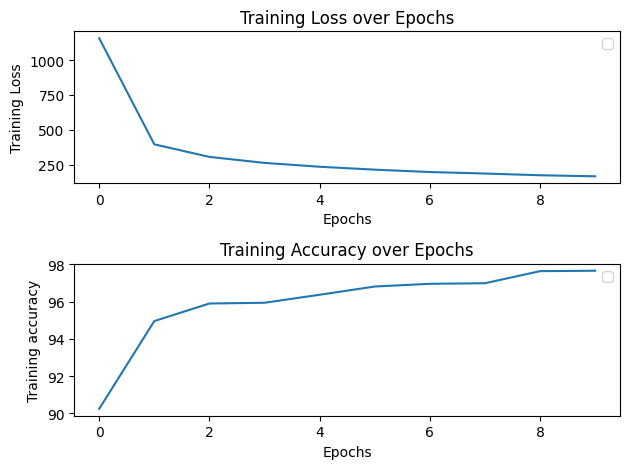

In [12]:
#plotting training loss and training accuracy
fig,axes = plt.subplots(2,1)
axes[0].plot(losses)
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Training Loss')
axes[0].set_title('Training Loss over Epochs')
axes[0].legend()

axes[1].plot(train_accuracy)
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Training accuracy')
axes[1].set_title('Training Accuracy over Epochs')
axes[1].legend()

plt.tight_layout()
plt.show()

## Model Evaluation: Test Accuracy

### `test_accuracy` Function
- Evaluates the trained CNN model on the test dataset.
- **Inputs:**
  - `X_test`: Test set inputs (images).
  - `Y_test`: Ground truth labels for the test set.
  - `params`: Dictionary of trained model parameters.
- **Process:**
  - Calls the `predict` function to get predicted labels.
  - Compares predictions with actual labels to compute the accuracy.
  - Prints and returns the test accuracy as a percentage.

> 💡 Example usage after training:
```python
test_acc = test_accuracy(X_test, Y_test, params)


In [13]:
def test_accuracy(X_test, Y_test, params):
    
    predictions = predict(X_test,params)
    
    # Calculate accuracy
    accuracy = np.sum(predictions == Y_test) / Y_test.size
    print(f"Test Accuracy: {accuracy*100:.4f}%")
    return accuracy

# Example usage after training:
test_acc = test_accuracy(X_test, Y_test, params)

Test Accuracy: 97.4600%
